# Roughness and microslicing

## Interfacial roughness

The slab model that has been discussed has a clear problem, it that it implies perfectly flat interfaces between different materials. 
These cannot exist in real materials, therefore it is necessary to enable **roughness** between the interfaces in our model. 
There are a range of functions that can be used to implement interfacial roughness in slab modelling.
However, the most common is the use of an error function {cite}`nevot_caracterisation_1980`, also known as **Nevot-Croce** roughness.

We can visualise a typical error function roughness below, where we show the silicon dioxide on silicon sample from before with a roughness of $0$ Å between each layer and with a roughness of $10$ Å between each layer. 
````{margin}
```{note}
The code used to obtain the scattering length density profile with roughness can be found in the [`helper.py`](https://github.com/arm61/isis_school/blob/main/reflectometry_slab_models/helper.py) module.
```
````

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from helper import sld_with_roughness, microslicing, abeles, abeles_with_roughness

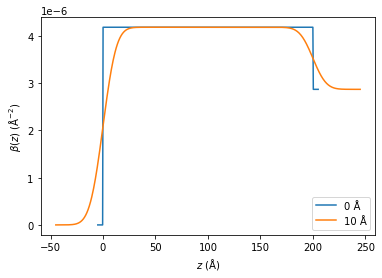

In [2]:
beta = np.array([0 + 0j, 4.186e-6 + 0j, 2.871e-6 + 0j])
d = np.array([0, 200, 0])
sigma = np.array([0, 0])
sigma2 = np.array([10, 10])
plt.plot(*sld_with_roughness(beta, d, sigma), label='0 Å')
plt.plot(*sld_with_roughness(beta, d, sigma2), label='10 Å')
plt.xlabel('$z$ (Å)')
plt.ylabel(r'$\beta(z)$ (Å$^{-2}$)')
plt.legend()
plt.show()

We can see that this roughness creates some smoothing of the interface between the layers. 
It is necessary that we modify the Abelès matrix formalism discussed previously to account for this smoothing. 
This is achieve by adapting the calculation of the Fresnel reflectance, 

$$r_{n, n+1}(q) = \frac{k_n(q) - k_{n+1}(q)}{k_n(q) + k_{n+1}(q)} \exp{(-2k_nk_{n+1}\sigma_{n,n+1}^2)},$$

where, $\sigma_{n, n+1}^2$ is the roughness width between the interfaces. 
We can use this to observe the effect that this interfacial roughness has on the resulting reflectometry profile, shown below. 
````{margin}
```{note}
Again, the code used to find the reflectivity with roughness (and without) can be found in the [`helper.py`](https://github.com/arm61/isis_school/blob/main/reflectometry_slab_models/helper.py) module.
```
````

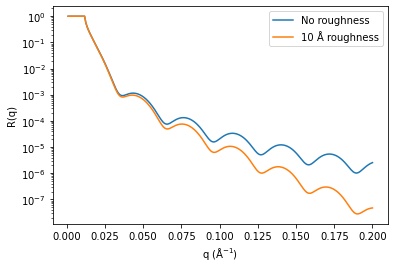

In [3]:
q = np.linspace(0.001, 0.2, 500)
beta = np.array([0 + 0j, 4.186e-6 + 0j, 2.871e-6 + 0j])
d = np.array([0, 200, 0])
r = abeles(q, beta, d)
sigma = np.array([10, 10])
r_with_roughness = abeles_with_roughness(q, beta, d, sigma)

plt.plot(q, r, label='No roughness')
plt.plot(q, r_with_roughness, label='10 Å roughness')
plt.xlabel('q (Å$^{-1}$)')
plt.ylabel('R(q)')
plt.yscale('log')
plt.legend()
plt.show()

## Problems with interfacial roughness

This method for considering interfacial roughness between two layers is not perfect, and if used incorrectly can introduce unphysical artifacts into our reflectometry calculation. 
Consider the example shown below, where there is a $10$ Å layer of nickel on a piece of titanium which is at the interface with air. 
The roughness between the nickel and air is increased from $3$ Å to $7$ Å with no roughness between the nickel and titanium. 

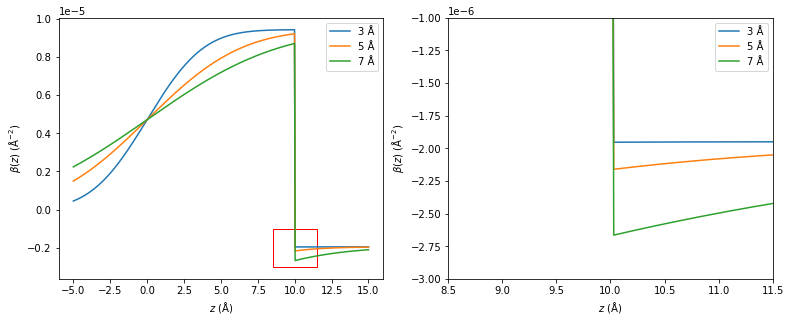

In [4]:
beta = np.array([0 + 0j, 9.4245e-06 + 0j, -1.9493e-06 + 0j])
d = np.array([0, 10, 0])
sigma3 = np.array([3, 0])
sigma5 = np.array([5, 0])
sigma7 = np.array([7, 0])

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

ax[0].plot(*sld_with_roughness(beta, d, sigma3), label='3 Å')
ax[0].plot(*sld_with_roughness(beta, d, sigma5), label='5 Å')
ax[0].plot(*sld_with_roughness(beta, d, sigma7), label='7 Å')
ax[0].set_xlabel('$z$ (Å)')
ax[0].set_ylabel(r'$\beta(z)$ (Å$^{-2}$)')
ax[0].legend()
ax[0].add_patch(Rectangle((8.5, -3e-6), 3, 2e-6, edgecolor='r', fill=False))

ax[1].plot(*sld_with_roughness(beta, d, sigma3), label='3 Å')
ax[1].plot(*sld_with_roughness(beta, d, sigma5), label='5 Å')
ax[1].plot(*sld_with_roughness(beta, d, sigma7), label='7 Å')
ax[1].set_xlabel('$z$ (Å)')
ax[1].set_ylabel(r'$\beta(z)$ (Å$^{-2}$)')
ax[1].set_xlim(8.5, 11.5)
ax[1].set_ylim(-3e-6, -1e-6)
ax[1].legend()

plt.show()

The red rectangle in the left hand plot identifies the region that is shown in the right hand plot.
From these figures, it is clear that the roughness between the nickel and air is leaking through to the nickel-titanium interface. 
This can lead to an unphysical interpretation of our system, if we interograte the scattering length density profile. 
Additionally, given that the roughness parameter only influences the Fresnel reflectance between two interfaces, this "leaking" through it **not** reflected in the resulting calculated data. 
````{margin}
```{note}
A common rule of thumb for using Nevot-Croce is that the roughness on an interface should be no more then $20$ % of the thickness of the shortest slab. 
```
````

## Microslicing

It is still possible that two layers may have an extremely rough interfaces which we would like to be able to model. 
Therefore, it is important that there is a methodology to work around this problem.
This method is **microslicing**, where the scattering length density profile is described as a series of very thin layers with no roughness between them. 
Consider the plot shown below, which shows the same interface as before, however this time comparing the Nevot-Croce approach and microslicing. 

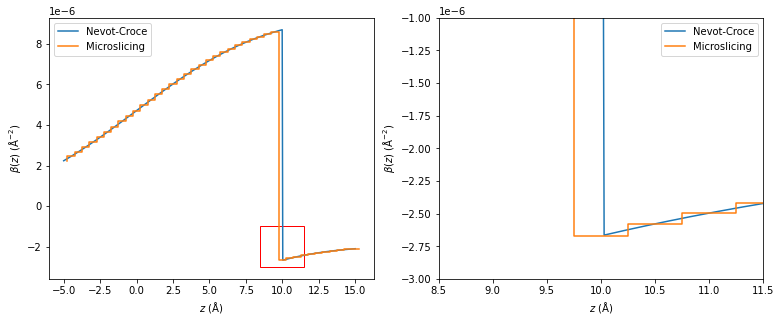

In [5]:
beta = np.array([0 + 0j, 9.4245e-06 + 0j, -1.9493e-06 + 0j])
d = np.array([0, 10, 0])
sigma7 = np.array([7, 0])

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

ax[0].plot(*sld_with_roughness(beta, d, sigma7), label='Nevot-Croce')
ax[0].step(*microslicing(beta, d, sigma7, 0.5), label='Microslicing')
ax[0].set_xlabel('$z$ (Å)')
ax[0].set_ylabel(r'$\beta(z)$ (Å$^{-2}$)')
ax[0].legend()
ax[0].add_patch(Rectangle((8.5, -3e-6), 3, 2e-6, edgecolor='r', fill=False))

ax[1].plot(*sld_with_roughness(beta, d, sigma7), label='Nevot-Croce')
ax[1].step(*microslicing(beta, d, sigma7, 0.5), label='Microslicing')
ax[1].set_xlabel('$z$ (Å)')
ax[1].set_ylabel(r'$\beta(z)$ (Å$^{-2}$)')
ax[1].set_xlim(8.5, 11.5)
ax[1].set_ylim(-3e-6, -1e-6)
ax[1].legend()

plt.show()

Notice that now the system is a series of layers with a thicknes of $0.5$ Å each. 
This means that by applying the Abelès matrix formalism to this profile, and ignoring any roughness, the reflectivity will be that for the (admittedly unphysical) system where the roughness **does** leak through. 
Below, we compare the two reflectometry profiles from the Nevot-Croce large roughness and the microsliced data, where we can see a clear difference.

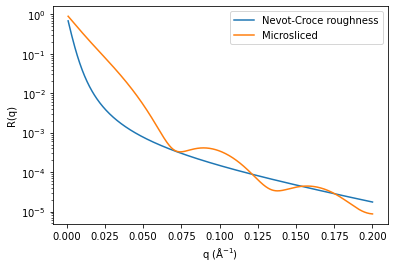

In [6]:
q = np.linspace(0.001, 0.2, 500)
beta = np.array([0 + 0j, 9.4245e-06 + 0j, -1.9493e-06 + 0j])
d = np.array([0, 10, 0])
sigma7 = np.array([7, 0])
r_nevot_croce = abeles_with_roughness(q, beta, d, sigma7)
d_microsliced, beta_microsliced = microslicing(beta, d, sigma7)
r_microsliced = abeles(q, beta_microsliced + 0j, d_microsliced)

plt.plot(q, r_nevot_croce, label='Nevot-Croce roughness')
plt.plot(q, r_microsliced, label='Microsliced')
plt.xlabel('q (Å$^{-1}$)')
plt.ylabel('R(q)')
plt.yscale('log')
plt.legend()
plt.show()